# Single transit search

In this notebook, we use `nuance` to search for a single transit. Let's generate some data first, of a unique planetary transit lost in a smooth stellar variability signal

In [1]:
# in order to run on all CPUs
import os
import jax

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7),
 CpuDevice(id=8),
 CpuDevice(id=9)]

/Users/lgrcia/code/dev/nuance/nuance/combined.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


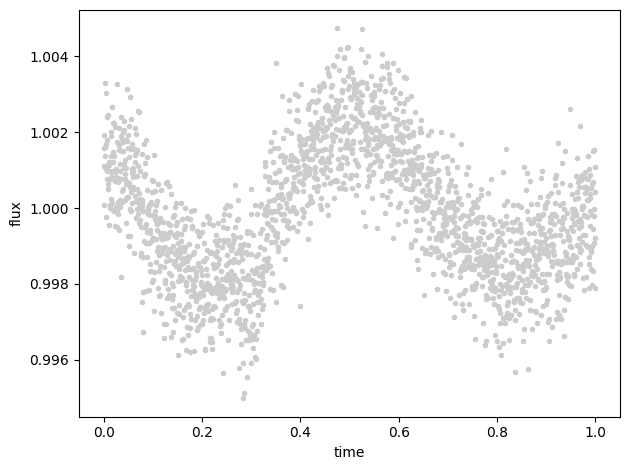

In [2]:
import matplotlib.pyplot as plt
from nuance import utils
import numpy as np

t = np.linspace(0, 1, 2000)
true = {"t0": 0.3, "D": 0.05, "P": 10, "depth": 1e-3}
(time, flux, error), X, gp = utils.simulated(time=t, **true)
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()

## The *linear search*

We start by instantiating a [Nuance](nuance.Nuance) object, and perform the *linear search* over all times (considered as potential transit epochs) and on a wide range of durations.

In [3]:
from nuance import Nuance, utils

nu = Nuance(time, flux, gp=gp, X=X)

t0s = time.copy()
Ds = np.linspace(0.01, 0.2, 15)
nu.linear_search(t0s, Ds)

  0%|          | 0/200 [00:00<?, ?it/s]

To have an idea of where the potential candidates might be, let's plot the unique transit log-likelihood computed during the linear search.

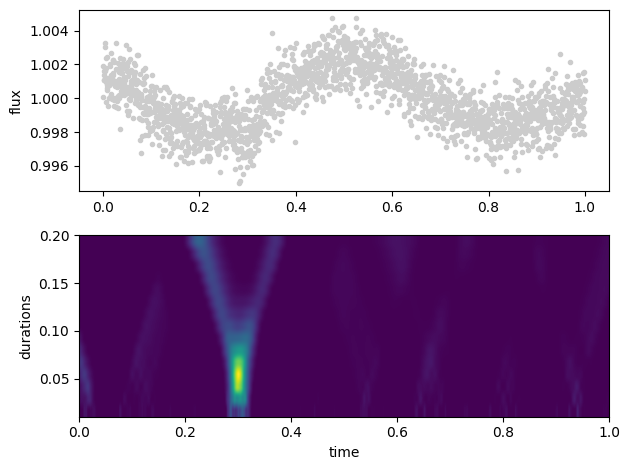

In [4]:
plt.subplot(211)
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")

plt.subplot(212)
nu.search_data.show_ll()
plt.ylabel("durations")
plt.xlabel("time")

plt.tight_layout()

We clearly identify a transit candidate, that we can plot thanks to its parameters

epoch: 0.301
duration: 0.051


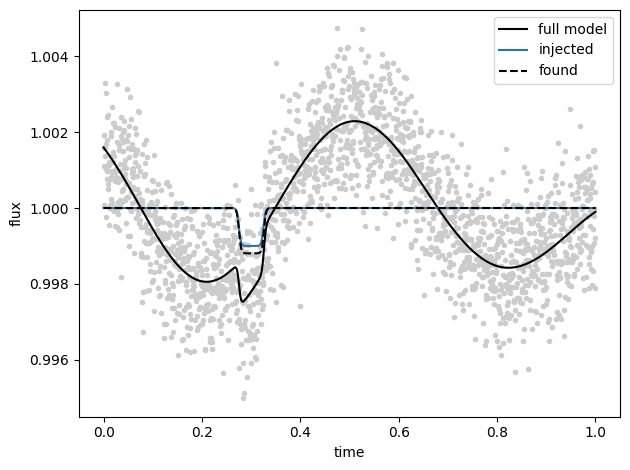

In [5]:
i, j = np.unravel_index(np.argmax(nu.search_data.ll), nu.search_data.ll.shape)
t0, D = nu.search_data.t0s[i], nu.search_data.Ds[j]
linear, astro, noise = nu.models(t0, D)
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, linear + astro + noise, c="k", label="full model")
plt.plot(
    time,
    true["depth"] * nu.model(t, D=true["D"], t0=true["t0"]) + 1.0,
    ls="-",
    c="C0",
    label="injected",
)
plt.plot(time, astro + 1.0, ls="--", c="k", label="found")
plt.legend()
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()
print("\n".join([f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration"], [t0, D])]))

Which is the one injected in the simulated dataset